In [29]:
import torch
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
from zoedepth.models.builder import build_model
from zoedepth.utils.config import get_config

In [3]:
cd ZoeDepth-main/

/home/irfan/Documents/ZoeDepth-main


In [4]:
ls

assets/          LICENSE                    README.md      train_test_inputs/
Datasets/        model_zoe_n_train_old.pth  sanity_hub.py  ui/
environment.yml  model_zoe_n_train.pth      sanity.py      wandb/
evaluate.py      notebooks/                 train_mix.py   zoedepth/
hubconf.py       pred.png                   train_mono.py


In [30]:
!nvidia-smi

Tue Nov 14 21:24:12 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.65.01    Driver Version: 515.65.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA TITAN RTX    On   | 00000000:1A:00.0 Off |                  N/A |
| 41%   38C    P8    29W / 280W |   6224MiB / 24576MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA TITAN RTX    On   | 00000000:68:00.0 Off |                  N/A |
| 41%   

In [7]:
torch.cuda.set_device(1)

Check to see if all dependencies are installed

In [4]:
!python sanity.py

/home/irfan/anaconda3/envs/zoe/lib/python3.9/site-packages/torch/hub.py:267: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or help(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use help(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/intel-isl/MiDaS/zipball/master" to /home/irfan/.cache/torch/hub/master.zip
******************** Testing zoedepth ********************
Config:
{'attractor_alpha': 1000,
 'attractor_gamma': 2,
 'attractor_kind': 'mean',
 'attractor_type': 'inv',
 'aug': True,
 'bin_centers_type': 'softplus',
 'bin_embed

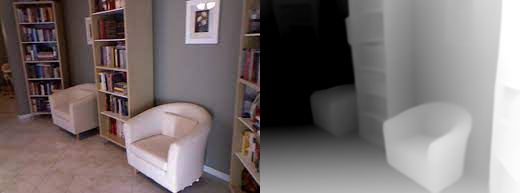

In [5]:
from IPython.display import Image, display

# Display an image from the specified path
image_path = 'pred.png'
display(Image(filename=image_path))

In [16]:
# ZoeD_N
conf = get_config("zoedepth", "infer")
model_zoe_n = build_model(conf)

# ZoeD_K
conf = get_config("zoedepth", "infer", config_version="kitti")
model_zoe_k = build_model(conf)

# ZoeD_NK
conf = get_config("zoedepth_nk", "infer")
model_zoe_nk = build_model(conf)

img_size [384, 512]


Using cache found in /home/irfan/.cache/torch/hub/intel-isl_MiDaS_master


Params passed to Resize transform:
	width:  512
	height:  384
	resize_target:  True
	keep_aspect_ratio:  True
	ensure_multiple_of:  32
	resize_method:  minimal
Using pretrained resource url::https://github.com/isl-org/ZoeDepth/releases/download/v1.0/ZoeD_M12_N.pt
Loaded successfully
Overwriting config with config_version kitti
img_size [384, 768]


Using cache found in /home/irfan/.cache/torch/hub/intel-isl_MiDaS_master


Params passed to Resize transform:
	width:  768
	height:  384
	resize_target:  True
	keep_aspect_ratio:  True
	ensure_multiple_of:  32
	resize_method:  minimal
Using pretrained resource url::https://github.com/isl-org/ZoeDepth/releases/download/v1.0/ZoeD_M12_K.pt
Loaded successfully
img_size [384, 512]


Using cache found in /home/irfan/.cache/torch/hub/intel-isl_MiDaS_master


Params passed to Resize transform:
	width:  512
	height:  384
	resize_target:  True
	keep_aspect_ratio:  True
	ensure_multiple_of:  32
	resize_method:  minimal
Using pretrained resource url::https://github.com/isl-org/ZoeDepth/releases/download/v1.0/ZoeD_M12_NK.pt
Loaded successfully


In [17]:
##### sample prediction
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
zoe = model_zoe_n.to(DEVICE)


# Local file
from PIL import Image
image_path = "Dataset/sync/basement_0001a/rgb_00000.jpg"  # Make sure this path is correct
image = Image.open(image_path).convert("RGB")
depth_numpy = zoe.infer_pil(image)  # as numpy

depth_pil = zoe.infer_pil(image, output_type="pil")  # as 16-bit PIL Image

depth_tensor = zoe.infer_pil(image, output_type="tensor")  # as torch tensor


# Colorize output
from zoedepth.utils.misc import colorize

colored = colorize(depth_numpy)

# save colored output
fpath_colored = "sync_0000.png"
Image.fromarray(colored).save(fpath_colored)

FileNotFoundError: [Errno 2] No such file or directory: 'Dataset/sync/basement_0001a/rgb_00000.jpg'

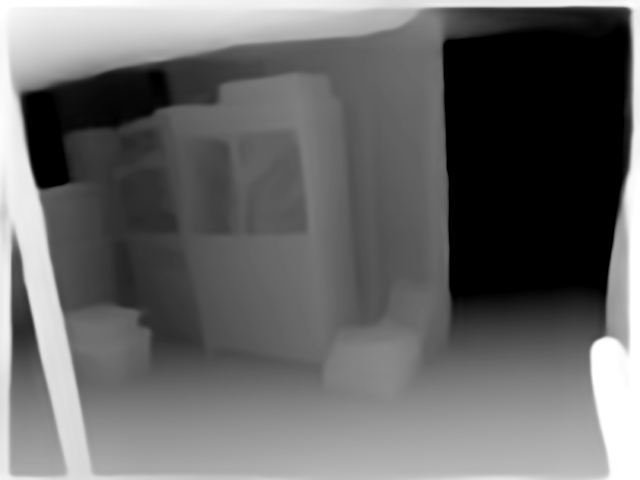

In [28]:
from IPython.display import Image, display

# Display an image from the specified path
image_path = 'sync_0000.png'
display(Image(filename=image_path))

In [20]:
def process_and_plot_images(model, image_dir, num_images=5):

    # Get the paths of the first `num_images` images in the directory
    image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.jpg')])[:num_images]
    images = [Image.open(os.path.join(image_dir, f)).convert("RGB") for f in image_files]
    
    # Process each image and save the output
    for image in images:
        depth_numpy = model.infer_pil(image)  # assuming model returns a numpy array
        depth_pil = model.infer_pil(image, output_type="pil")
        
        # Display the original and depth images side by side
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))
        axs[0].imshow(image)
        axs[0].set_title('Original Image')
        axs[0].axis('off')

        axs[1].imshow(depth_pil, cmap='gray')
        axs[1].set_title('Depth Image')
        axs[1].axis('off')



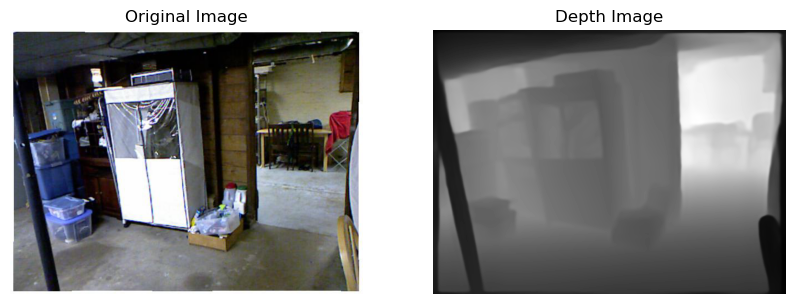

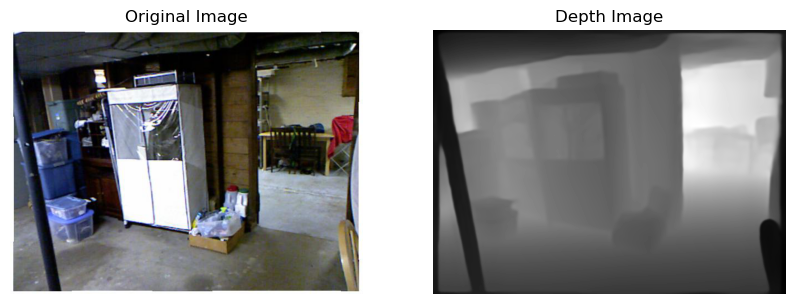

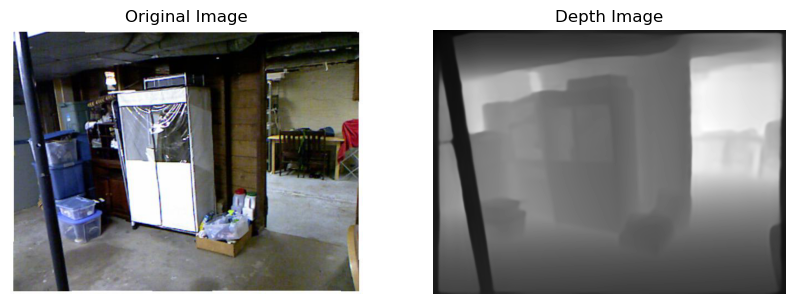

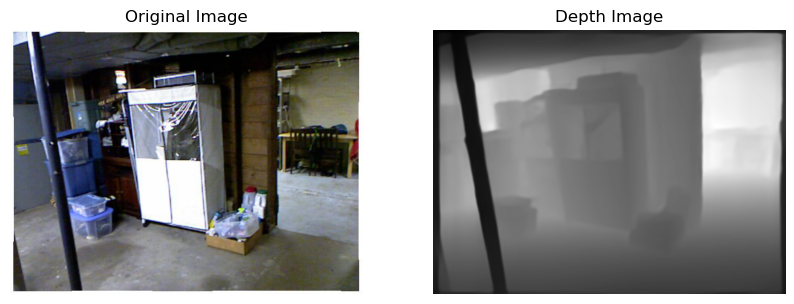

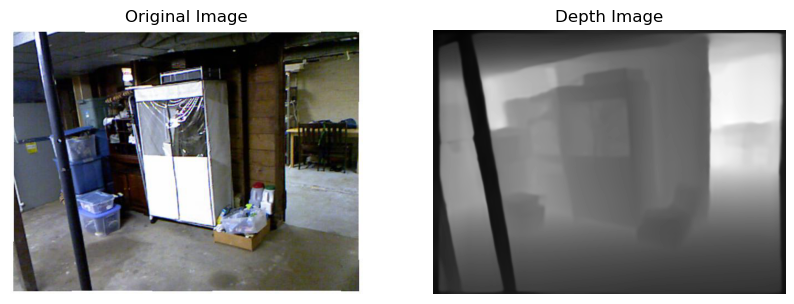

In [18]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
zoe_n = model_zoe_n.to(DEVICE)
image_dir = 'Datasets/nyu_depth_v2/sync/basement_0001a/'  # Path where the input images are stored

# Call the function with the required arguments
process_and_plot_images(zoe_n, image_dir)

ZOE kitti Model

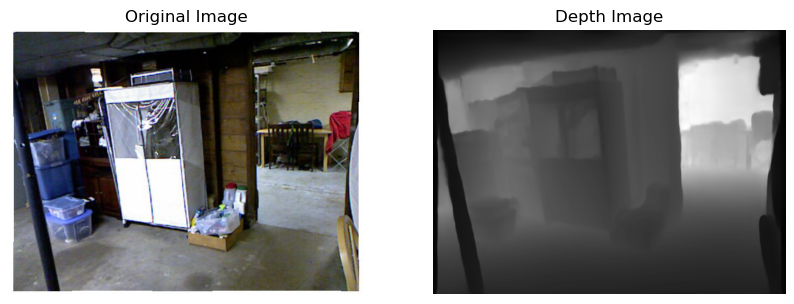

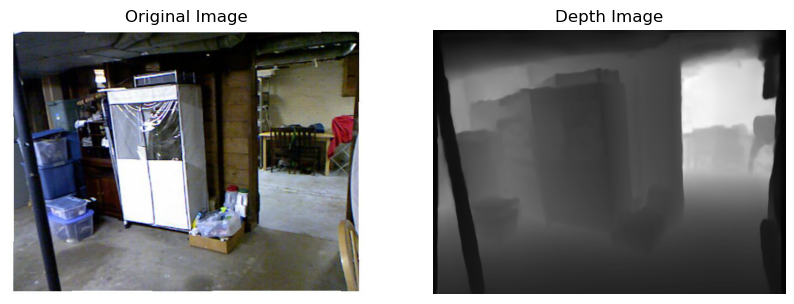

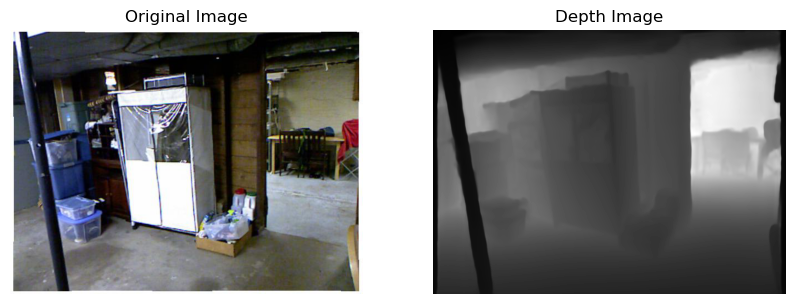

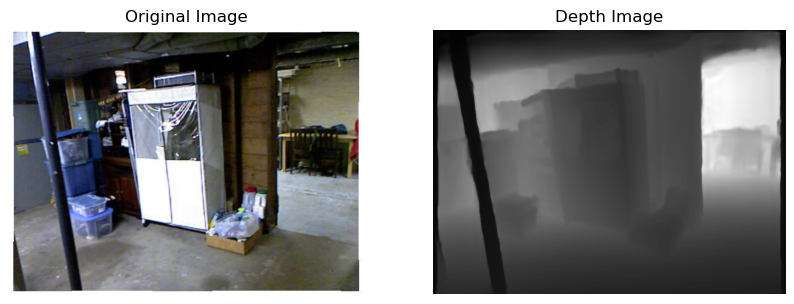

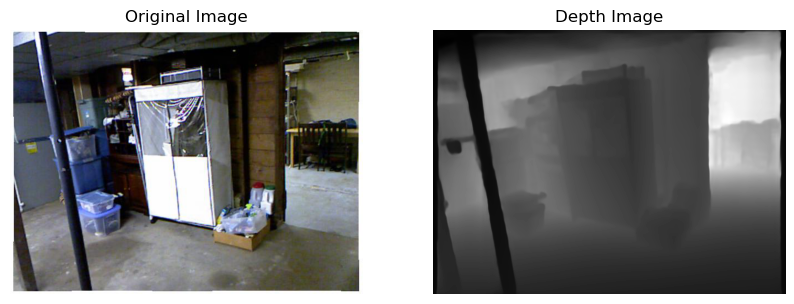

In [16]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
zoe_k = model_zoe_k.to(DEVICE)
image_dir = 'Datasets/nyu_depth_v2/sync/basement_0001a/'  # Path where the input images are stored

# Call the function with the required arguments
process_and_plot_images(zoe_k, image_dir)

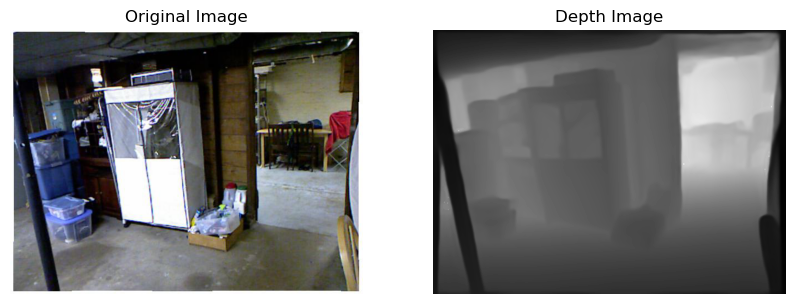

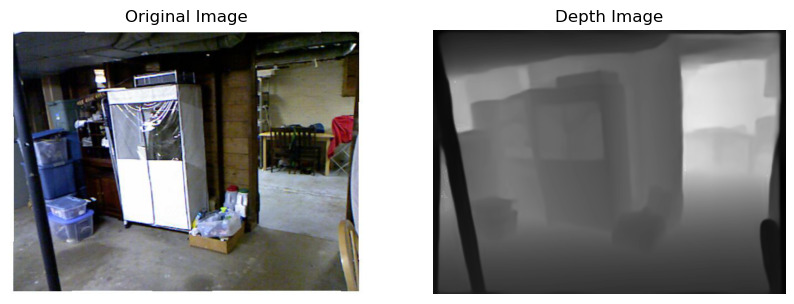

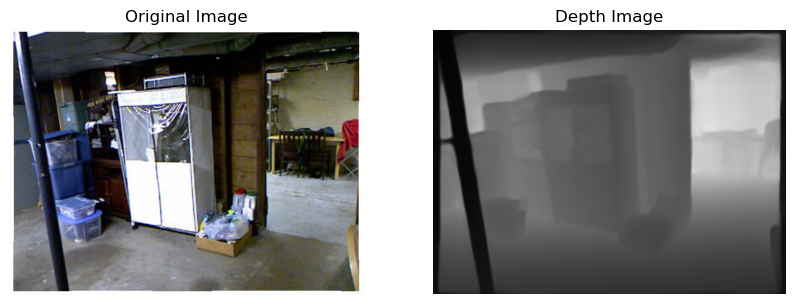

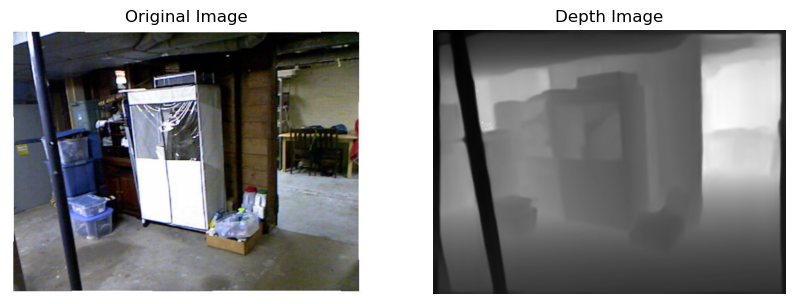

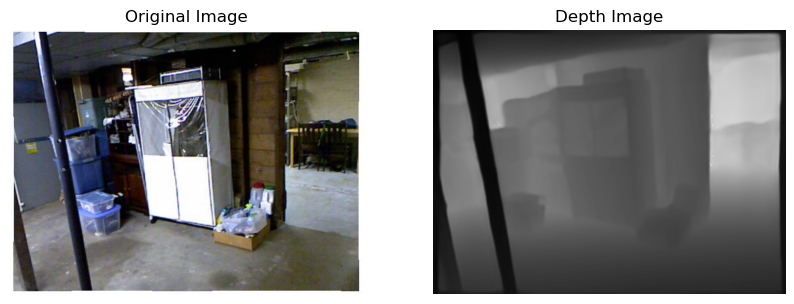

In [17]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
zoe_nk = model_zoe_nk.to(DEVICE)
image_dir = 'Datasets/nyu_depth_v2/sync/basement_0001a/'  # Path where the input images are stored

# Call the function with the required arguments
process_and_plot_images(zoe_nk, image_dir)

In [8]:
conf = get_config("zoedepth", "train")
model_zoe_n_train = build_model(conf)

img_size [384, 512]


Using cache found in /home/irfan/.cache/torch/hub/intel-isl_MiDaS_master
/home/irfan/anaconda3/envs/zoe/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525539683/work/aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Params passed to Resize transform:
	width:  512
	height:  384
	resize_target:  True
	keep_aspect_ratio:  False
	ensure_multiple_of:  32
	resize_method:  minimal


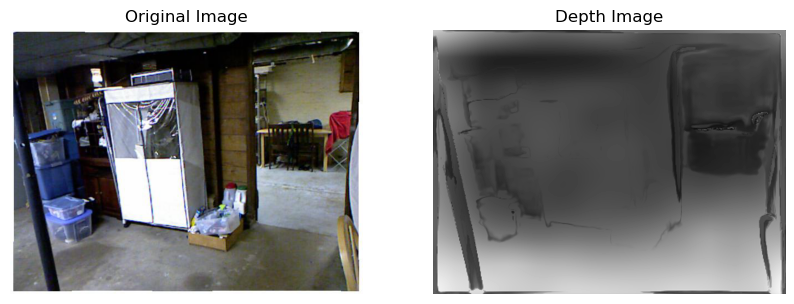

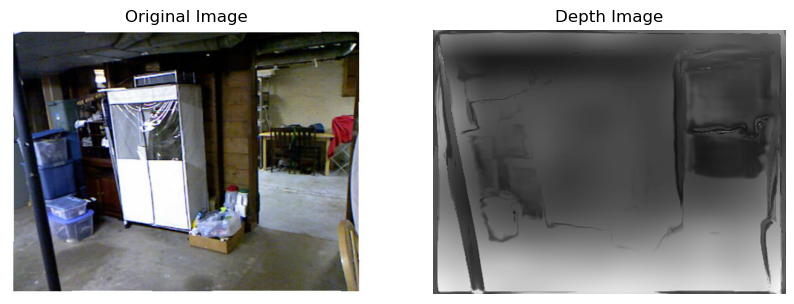

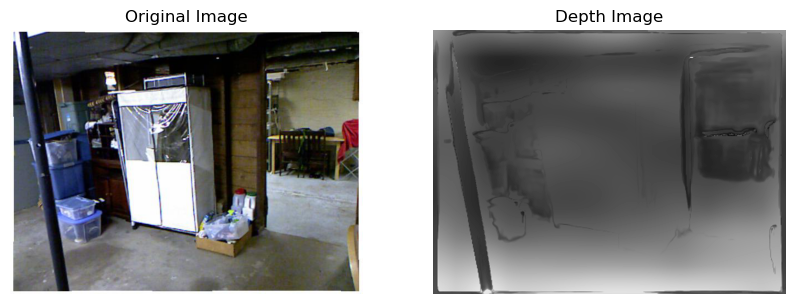

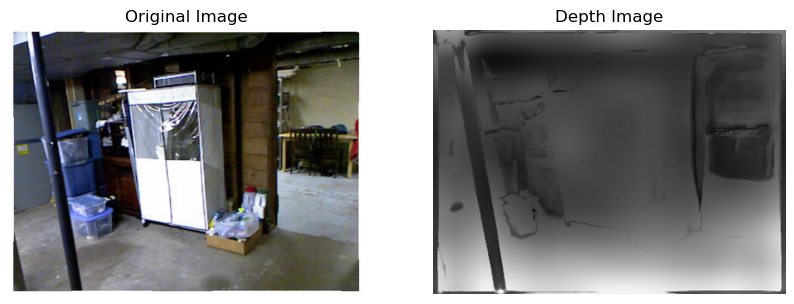

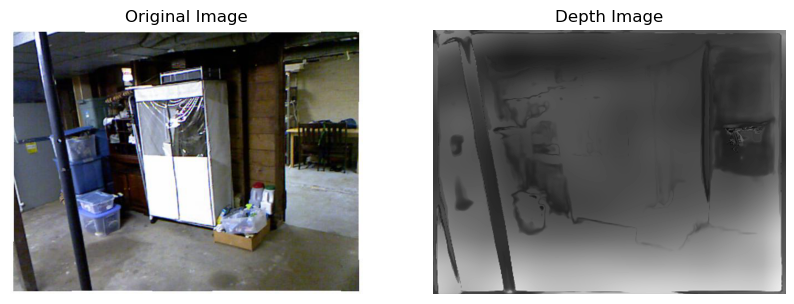

In [8]:
DEVICE = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
zoe_n_train = model_zoe_n_train.to(DEVICE)
image_dir = 'Datasets/nyu_depth_v2/sync/basement_0001a/'  # Path where the input images are stored

# Call the function with the required arguments
process_and_plot_images(zoe_n_train, image_dir)

Extract test dataset

In [18]:
! wget http://horatio.cs.nyu.edu/mit/silberman/nyu_depth_v2/nyu_depth_v2_labeled.mat
### Convert mat file to image files
! python extract_official_train_test_set_from_mat.py nyu_depth_v2_labeled.mat splits.mat Datasets/nyu_depth_v2/official_splits/


795 training images
654 test images
reading nyu_depth_v2_labeled.mat
processing images
image 1 / 1449
Traceback (most recent call last):
  File "/home/irfan/Documents/ZoeDepth-main/extract_official_train_test_set_from_mat.py", line 95, in <module>
    convert_image(i, scenes[i], depth_raw[i, :, :].T, image.T)
  File "/home/irfan/Documents/ZoeDepth-main/extract_official_train_test_set_from_mat.py", line 55, in convert_image
    os.makedirs(folder)
  File "/home/irfan/anaconda3/envs/zoe/lib/python3.9/os.py", line 215, in makedirs
    makedirs(head, exist_ok=exist_ok)
  File "/home/irfan/anaconda3/envs/zoe/lib/python3.9/os.py", line 215, in makedirs
    makedirs(head, exist_ok=exist_ok)
  File "/home/irfan/anaconda3/envs/zoe/lib/python3.9/os.py", line 215, in makedirs
    makedirs(head, exist_ok=exist_ok)
  [Previous line repeated 1 more time]
  File "/home/irfan/anaconda3/envs/zoe/lib/python3.9/os.py", line 225, in makedirs
    mkdir(name, mode)
PermissionError: [Errno 13] Permission den

In [9]:
wandb login

In [10]:
torch.save(model_zoe_n_train.state_dict(), 'model_zoe_n_train.pth')

In [19]:
!python train_mono.py -m zoedepth --pretrained_resource="local::model_zoe_n_train.pth"

0
tcp://127.0.0.1:15003
Config:
{'attractor_alpha': 1000,
 'attractor_gamma': 2,
 'attractor_kind': 'mean',
 'attractor_type': 'inv',
 'aug': True,
 'avoid_boundary': False,
 'batch_size': 4,
 'bin_centers_type': 'softplus',
 'bin_embedding_dim': 128,
 'bs': 4,
 'clip_grad': 0.1,
 'cycle_momentum': True,
 'data_path': './Datasets/nyu_depth_v2/sync/',
 'data_path_eval': './Datasets/nyu_depth_v2/test/',
 'dataset': 'nyu',
 'degree': 1.0,
 'dist_backend': 'nccl',
 'dist_url': 'tcp://127.0.0.1:15003',
 'distributed': True,
 'div_factor': 1,
 'do_kb_crop': False,
 'do_random_rotate': True,
 'eigen_crop': True,
 'encoder_lr_factor': 10,
 'epochs': 5,
 'filenames_file': './train_test_inputs/nyudepthv2_train_files_with_gt.txt',
 'filenames_file_eval': './train_test_inputs/nyudepthv2_test_files_with_gt.txt',
 'final_div_factor': 10000,
 'freeze_midas_bn': True,
 'garg_crop': False,
 'gpu': None,
 'gt_path': './Datasets/nyu_depth_v2/sync/',
 'gt_path_eval': './Datasets/nyu_depth_v2/test/',
 'img

Epoch: 1/5. Loop: Validation:   0%|             | 1/654 [00:03<37:29,  3.45s/it]WARNING:root:Images sizes do not match. This will causes images to be display incorrectly in the UI.

Epoch: 1/5. Loop: Validation:  14%|█▋          | 94/654 [00:20<01:37,  5.75it/s]


Epoch: 1/5. Loop: Validation:  29%|███▏       | 191/654 [00:37<01:19,  5.81it/s]


Epoch: 1/5. Loop: Validation:  44%|████▊      | 288/654 [00:54<01:04,  5.63it/s]


Epoch: 1/5. Loop: Validation:  59%|██████▍    | 385/654 [01:11<00:47,  5.69it/s]


Epoch: 1/5. Loop: Validation:  74%|████████   | 482/654 [01:28<00:28,  6.02it/s]


Epoch: 1/5. Loop: Validation:  89%|█████████▋ | 579/654 [01:45<00:13,  5.37it/s]


Epoch: 1/5. Loop: Validation:   0%|             | 1/654 [00:02<23:19,  2.14s/it]WARNING:root:Images sizes do not match. This will causes images to be display incorrectly in the UI.

Epoch: 1/5. Loop: Validation:   3%|▎           | 19/654 [00:05<01:56,  5.45it/s]


Epoch: 1/5. Loop: Validation:  18%|█▉         | 116/654 [00:22<01:32,  5.80it/s]


Epoch: 1/5. Loop: Validation:  33%|███▌       | 213/654 [00:39<01:23,  5.30it/s]


Epoch: 1/5. Loop: Validation:  47%|█████▏     | 310/654 [00:57<01:00,  5.71it/s]


Epoch: 1/5. Loop: Validation:  62%|██████▊    | 407/654 [01:14<00:43,  5.73it/s]


Epoch: 1/5. Loop: Validation:  77%|████████▍  | 504/654 [01:31<00:25,  5.88it/s]


Epoch: 1/5. Loop: Validation:  92%|██████████ | 601/654 [01:48<00:09,  5.83it/s]


Epoch: 1/5. Loop: Validation:   0%|             | 1/654 [00:02<24:24,  2.24s/it]WARNING:root:Images sizes do not match. This will causes images to be display incorrectly in the UI.

Epoch: 1/5. Loop: Validation:   6%|▊           | 41/654 [00:09<01:41,  6.06it/s]


Epoch: 1/5. Loop: Validation:  21%|██▎        | 138/654 [00:26<01:32,  5.57it/s]


Epoch: 1/5. Loop: Validation:  36%|███▉       | 235/654 [00:43<01:11,  5.87it/s]


Epoch: 1/5. Loop: Validation:  51%|█████▌     | 332/654 [01:00<00:55,  5.75it/s]


Epoch: 1/5. Loop: Validation:  66%|███████▏   | 429/654 [01:17<00:40,  5.59it/s]


Epoch: 1/5. Loop: Validation:  80%|████████▊  | 526/654 [01:34<00:21,  5.82it/s]


Epoch: 1/5. Loop: Validation:  95%|██████████▍| 623/654 [01:51<00:05,  5.86it/s]


Epoch: 1/5. Loop: Validation:   0%|             | 1/654 [00:02<25:27,  2.34s/it]WARNING:root:Images sizes do not match. This will causes images to be display incorrectly in the UI.

Epoch: 1/5. Loop: Validation:  10%|█▏          | 63/654 [00:13<01:42,  5.76it/s]


Epoch: 1/5. Loop: Validation:  24%|██▋        | 160/654 [00:30<01:27,  5.67it/s]


Epoch: 1/5. Loop: Validation:  39%|████▎      | 257/654 [00:47<01:06,  5.97it/s]


Epoch: 1/5. Loop: Validation:  54%|█████▉     | 354/654 [01:04<00:55,  5.44it/s]


Epoch: 1/5. Loop: Validation:  69%|███████▌   | 451/654 [01:21<00:34,  5.80it/s]


Epoch: 1/5. Loop: Validation:  84%|█████████▏ | 548/654 [01:38<00:18,  5.71it/s]


Epoch: 1/5. Loop: Validation:  99%|██████████▊| 645/654 [01:55<00:01,  5.61it/s]


Epoch: 2/5. Loop: Validation:   0%|             | 1/654 [00:02<25:22,  2.33s/it]WARNING:root:Images sizes do not match. This will causes images to be display incorrectly in the UI.

Epoch: 2/5. Loop: Validation:  13%|█▌          | 84/654 [00:16<01:38,  5.80it/s]


Epoch: 2/5. Loop: Validation:  28%|███        | 181/654 [00:34<01:22,  5.74it/s]


Epoch: 2/5. Loop: Validation:  43%|████▋      | 278/654 [00:50<01:04,  5.84it/s]


Epoch: 2/5. Loop: Validation:  57%|██████▎    | 375/654 [01:07<00:49,  5.68it/s]


Epoch: 2/5. Loop: Validation:  72%|███████▉   | 472/654 [01:24<00:31,  5.69it/s]


Epoch: 2/5. Loop: Validation:  87%|█████████▌ | 569/654 [01:41<00:14,  5.70it/s]


Epoch: 2/5. Loop: Validation:   0%|             | 1/654 [00:02<23:01,  2.12s/it]WARNING:root:Images sizes do not match. This will causes images to be display incorrectly in the UI.

Epoch: 2/5. Loop: Validation:   1%|▏            | 9/654 [00:03<02:26,  4.39it/s]


Epoch: 2/5. Loop: Validation:  16%|█▊         | 106/654 [00:20<01:34,  5.77it/s]


Epoch: 2/5. Loop: Validation:  31%|███▍       | 203/654 [00:37<01:18,  5.76it/s]


Epoch: 2/5. Loop: Validation:  46%|█████      | 300/654 [00:54<01:02,  5.63it/s]


Epoch: 2/5. Loop: Validation:  61%|██████▋    | 397/654 [01:11<00:45,  5.60it/s]


Epoch: 2/5. Loop: Validation:  76%|████████▎  | 494/654 [01:28<00:32,  4.94it/s]


Epoch: 2/5. Loop: Validation:  90%|█████████▉ | 591/654 [01:45<00:10,  6.25it/s]


Epoch: 2/5. Loop: Validation:   0%|             | 1/654 [00:02<24:45,  2.27s/it]WARNING:root:Images sizes do not match. This will causes images to be display incorrectly in the UI.

Epoch: 2/5. Loop: Validation:   5%|▌           | 31/654 [00:07<01:47,  5.81it/s]


Epoch: 2/5. Loop: Validation:  20%|██▏        | 128/654 [00:24<01:32,  5.68it/s]


Epoch: 2/5. Loop: Validation:  34%|███▊       | 225/654 [00:41<01:15,  5.68it/s]


Epoch: 2/5. Loop: Validation:  49%|█████▍     | 322/654 [00:58<00:58,  5.72it/s]


Epoch: 2/5. Loop: Validation:  64%|███████    | 419/654 [01:15<00:41,  5.66it/s]


Epoch: 2/5. Loop: Validation:  79%|████████▋  | 516/654 [01:32<00:24,  5.56it/s]


Epoch: 2/5. Loop: Validation:  94%|██████████▎| 613/654 [01:49<00:07,  5.65it/s]


Epoch: 2/5. Loop: Validation:   0%|             | 1/654 [00:02<25:23,  2.33s/it]WARNING:root:Images sizes do not match. This will causes images to be display incorrectly in the UI.

Epoch: 2/5. Loop: Validation:   8%|▉           | 53/654 [00:11<01:41,  5.89it/s]


Epoch: 2/5. Loop: Validation:  23%|██▌        | 150/654 [00:29<01:26,  5.83it/s]


Epoch: 2/5. Loop: Validation:  38%|████▏      | 247/654 [00:45<01:08,  5.97it/s]


Epoch: 2/5. Loop: Validation:  53%|█████▊     | 344/654 [01:02<00:55,  5.57it/s]


Epoch: 2/5. Loop: Validation:  67%|███████▍   | 441/654 [01:19<00:37,  5.62it/s]


Epoch: 2/5. Loop: Validation:  82%|█████████  | 538/654 [01:36<00:19,  5.81it/s]


Epoch: 2/5. Loop: Validation:  97%|██████████▋| 635/654 [01:52<00:03,  5.81it/s]


Epoch: 3/5. Loop: Validation:   0%|             | 1/654 [00:02<22:23,  2.06s/it]WARNING:root:Images sizes do not match. This will causes images to be display incorrectly in the UI.

Epoch: 3/5. Loop: Validation:  11%|█▎          | 74/654 [00:14<01:38,  5.90it/s]


Epoch: 3/5. Loop: Validation:  26%|██▉        | 171/654 [00:31<01:26,  5.61it/s]


Epoch: 3/5. Loop: Validation:  41%|████▌      | 268/654 [00:48<01:06,  5.77it/s]


Epoch: 3/5. Loop: Validation:  56%|██████▏    | 365/654 [01:05<00:50,  5.72it/s]


Epoch: 3/5. Loop: Validation:  71%|███████▊   | 462/654 [01:22<00:32,  5.88it/s]


Epoch: 3/5. Loop: Validation:  85%|█████████▍ | 559/654 [01:39<00:16,  5.84it/s]


Epoch: 3/5. Loop: Validation:   0%|                     | 0/654 [00:00<?, ?it/s]


Epoch: 3/5. Loop: Validation:   0%|             | 1/654 [00:02<25:30,  2.34s/it]WARNING:root:Images sizes do not match. This will causes images to be display incorrectly in the UI.

Epoch: 3/5. Loop: Validation:  15%|█▊          | 96/654 [00:19<01:37,  5.72it/s]


Epoch: 3/5. Loop: Validation:  30%|███▏       | 193/654 [00:36<01:20,  5.70it/s]


Epoch: 3/5. Loop: Validation:  44%|████▉      | 290/654 [00:53<01:02,  5.83it/s]


Epoch: 3/5. Loop: Validation:  59%|██████▌    | 387/654 [01:10<00:52,  5.06it/s]


Epoch: 3/5. Loop: Validation:  74%|████████▏  | 484/654 [01:26<00:29,  5.75it/s]


Epoch: 3/5. Loop: Validation:  89%|█████████▊ | 581/654 [01:43<00:12,  5.81it/s]


Epoch: 3/5. Loop: Validation:   0%|             | 1/654 [00:02<24:37,  2.26s/it]WARNING:root:Images sizes do not match. This will causes images to be display incorrectly in the UI.

Epoch: 3/5. Loop: Validation:   3%|▍           | 21/654 [00:05<01:48,  5.81it/s]


Epoch: 3/5. Loop: Validation:  18%|█▉         | 118/654 [00:22<01:31,  5.84it/s]


Epoch: 3/5. Loop: Validation:  33%|███▌       | 215/654 [00:39<01:17,  5.66it/s]


Epoch: 3/5. Loop: Validation:  48%|█████▏     | 312/654 [00:56<00:59,  5.76it/s]


Epoch: 3/5. Loop: Validation:  63%|██████▉    | 409/654 [01:13<00:41,  5.89it/s]


Epoch: 3/5. Loop: Validation:  77%|████████▌  | 506/654 [01:30<00:24,  6.10it/s]


Epoch: 3/5. Loop: Validation:  92%|██████████▏| 603/654 [01:46<00:08,  5.81it/s]


Epoch: 3/5. Loop: Validation:   0%|             | 1/654 [00:02<24:54,  2.29s/it]WARNING:root:Images sizes do not match. This will causes images to be display incorrectly in the UI.

Epoch: 3/5. Loop: Validation:   7%|▊           | 43/654 [00:09<01:46,  5.76it/s]


Epoch: 3/5. Loop: Validation:  21%|██▎        | 140/654 [00:26<01:30,  5.65it/s]


Epoch: 3/5. Loop: Validation:  36%|███▉       | 237/654 [00:43<01:13,  5.66it/s]


Epoch: 3/5. Loop: Validation:  51%|█████▌     | 334/654 [01:00<00:55,  5.77it/s]


Epoch: 3/5. Loop: Validation:  66%|███████▏   | 431/654 [01:17<00:38,  5.77it/s]


Epoch: 3/5. Loop: Validation:  81%|████████▉  | 528/654 [01:34<00:21,  5.74it/s]


Epoch: 3/5. Loop: Validation:  96%|██████████▌| 625/654 [01:50<00:04,  5.91it/s]


Epoch: 4/5. Loop: Validation:   0%|             | 1/654 [00:02<23:05,  2.12s/it]WARNING:root:Images sizes do not match. This will causes images to be display incorrectly in the UI.

Epoch: 4/5. Loop: Validation:  10%|█▏          | 64/654 [00:13<01:39,  5.92it/s]


Epoch: 4/5. Loop: Validation:  25%|██▋        | 161/654 [00:30<01:26,  5.67it/s]


Epoch: 4/5. Loop: Validation:  39%|████▎      | 258/654 [00:46<01:09,  5.74it/s]


Epoch: 4/5. Loop: Validation:  54%|█████▉     | 355/654 [01:04<00:51,  5.78it/s]


Epoch: 4/5. Loop: Validation:  69%|███████▌   | 452/654 [01:20<00:34,  5.78it/s]


Epoch: 4/5. Loop: Validation:  84%|█████████▏ | 549/654 [01:37<00:18,  5.70it/s]


Epoch: 4/5. Loop: Validation:  99%|██████████▊| 646/654 [01:53<00:01,  6.20it/s]


Epoch: 4/5. Loop: Validation:   0%|             | 1/654 [00:02<24:53,  2.29s/it]WARNING:root:Images sizes do not match. This will causes images to be display incorrectly in the UI.

Epoch: 4/5. Loop: Validation:  13%|█▌          | 86/654 [00:17<01:34,  6.02it/s]


Epoch: 4/5. Loop: Validation:  28%|███        | 183/654 [00:34<01:21,  5.77it/s]


Epoch: 4/5. Loop: Validation:  43%|████▋      | 280/654 [00:50<01:02,  5.95it/s]


Epoch: 4/5. Loop: Validation:  58%|██████▎    | 377/654 [01:07<00:47,  5.79it/s]


Epoch: 4/5. Loop: Validation:  72%|███████▉   | 474/654 [01:24<00:31,  5.80it/s]


Epoch: 4/5. Loop: Validation:  87%|█████████▌ | 571/654 [01:41<00:14,  5.64it/s]


Epoch: 4/5. Loop: Validation:   0%|             | 1/654 [00:02<23:55,  2.20s/it]WARNING:root:Images sizes do not match. This will causes images to be display incorrectly in the UI.

Epoch: 4/5. Loop: Validation:   2%|▏           | 11/654 [00:04<02:01,  5.27it/s]


Epoch: 4/5. Loop: Validation:  17%|█▊         | 108/654 [00:20<01:26,  6.34it/s]


Epoch: 4/5. Loop: Validation:  31%|███▍       | 205/654 [00:37<01:16,  5.88it/s]


Epoch: 4/5. Loop: Validation:  46%|█████      | 302/654 [00:54<01:02,  5.64it/s]


Epoch: 4/5. Loop: Validation:  61%|██████▋    | 399/654 [01:11<00:42,  6.02it/s]


Epoch: 4/5. Loop: Validation:  76%|████████▎  | 496/654 [01:28<00:30,  5.23it/s]


Epoch: 4/5. Loop: Validation:  91%|█████████▉ | 593/654 [01:45<00:09,  6.28it/s]


Epoch: 4/5. Loop: Validation:   0%|             | 1/654 [00:02<25:12,  2.32s/it]WARNING:root:Images sizes do not match. This will causes images to be display incorrectly in the UI.

Epoch: 4/5. Loop: Validation:   5%|▌           | 33/654 [00:08<01:50,  5.64it/s]


Epoch: 4/5. Loop: Validation:  20%|██▏        | 130/654 [00:25<01:33,  5.62it/s]


Epoch: 4/5. Loop: Validation:  35%|███▊       | 227/654 [00:41<01:15,  5.69it/s]


Epoch: 4/5. Loop: Validation:  50%|█████▍     | 324/654 [00:58<01:02,  5.28it/s]


Epoch: 4/5. Loop: Validation:  64%|███████    | 421/654 [01:15<00:40,  5.72it/s]


Epoch: 4/5. Loop: Validation:  79%|████████▋  | 518/654 [01:32<00:23,  5.70it/s]


Epoch: 4/5. Loop: Validation:  94%|██████████▎| 615/654 [01:49<00:06,  6.05it/s]


Epoch: 5/5. Loop: Validation:   0%|             | 1/654 [00:02<22:32,  2.07s/it]WARNING:root:Images sizes do not match. This will causes images to be display incorrectly in the UI.

Epoch: 5/5. Loop: Validation:   8%|▉           | 54/654 [00:11<01:43,  5.82it/s]


Epoch: 5/5. Loop: Validation:  23%|██▌        | 151/654 [00:28<01:42,  4.89it/s]


Epoch: 5/5. Loop: Validation:  38%|████▏      | 248/654 [00:45<01:09,  5.84it/s]


Epoch: 5/5. Loop: Validation:  53%|█████▊     | 345/654 [01:02<00:54,  5.64it/s]


Epoch: 5/5. Loop: Validation:  68%|███████▍   | 442/654 [01:19<00:38,  5.53it/s]


Epoch: 5/5. Loop: Validation:  82%|█████████  | 539/654 [01:36<00:19,  5.85it/s]


Epoch: 5/5. Loop: Validation:  97%|██████████▋| 636/654 [01:53<00:02,  6.23it/s]


Epoch: 5/5. Loop: Validation:   0%|             | 1/654 [00:02<22:46,  2.09s/it]WARNING:root:Images sizes do not match. This will causes images to be display incorrectly in the UI.

Epoch: 5/5. Loop: Validation:  12%|█▍          | 76/654 [00:15<01:32,  6.22it/s]


Epoch: 5/5. Loop: Validation:  26%|██▉        | 173/654 [00:32<01:26,  5.57it/s]


Epoch: 5/5. Loop: Validation:  41%|████▌      | 270/654 [00:49<01:13,  5.21it/s]


Epoch: 5/5. Loop: Validation:  56%|██████▏    | 367/654 [01:06<00:48,  5.92it/s]


Epoch: 5/5. Loop: Validation:  71%|███████▊   | 464/654 [01:23<00:30,  6.14it/s]


Epoch: 5/5. Loop: Validation:  86%|█████████▍ | 561/654 [01:40<00:17,  5.32it/s]


Epoch: 5/5. Loop: Validation:   0%|             | 1/654 [00:02<25:38,  2.36s/it]WARNING:root:Images sizes do not match. This will causes images to be display incorrectly in the UI.



Epoch: 5/5. Loop: Validation:  15%|█▊          | 98/654 [00:19<01:34,  5.89it/s]


Epoch: 5/5. Loop: Validation:  30%|███▎       | 195/654 [00:36<01:21,  5.63it/s]


Epoch: 5/5. Loop: Validation:  45%|████▉      | 292/654 [00:53<01:01,  5.90it/s]


Epoch: 5/5. Loop: Validation:  59%|██████▌    | 389/654 [01:10<00:43,  6.12it/s]


Epoch: 5/5. Loop: Validation:  74%|████████▏  | 486/654 [01:27<00:29,  5.62it/s]


Epoch: 5/5. Loop: Validation:  89%|█████████▊ | 583/654 [01:44<00:12,  5.77it/s]


Epoch: 5/5. Loop: Validation:   0%|             | 1/654 [00:02<24:18,  2.23s/it]WARNING:root:Images sizes do not match. This will causes images to be display incorrectly in the UI.

Epoch: 5/5. Loop: Validation:   4%|▍           | 23/654 [00:06<01:49,  5.77it/s]


Epoch: 5/5. Loop: Validation:  18%|██         | 120/654 [00:23<01:37,  5.47it/s]


Epoch: 5/5. Loop: Validation:  33%|███▋       | 217/654 [00:40<01:17,  5.64it/s]


Epoch: 5/5. Loop: Validation:  48%|█████▎     | 314/654 [00:56<00:58,  5.79it/s]


Epoch: 5/5. Loop: Validation:  63%|██████▉    | 411/654 [01:13<00:41,  5.85it/s]


Epoch: 5/5. Loop: Validation:  78%|████████▌  | 508/654 [01:30<00:26,  5.44it/s]


Epoch: 5/5. Loop: Validation:  93%|██████████▏| 605/654 [01:47<00:07,  6.26it/s]


Epoch: 5/5. Loop: Validation: 100%|███████████| 654/654 [01:56<00:00,  5.61it/s]
wandb: Waiting for W&B process to finish... (success).
wandb: \ 28.904 MB of 28.904 MB uploaded (0.000 MB deduped)
wandb: Run history:
wandb:            Epoch ▁▃▅▆█
wandb:       Metrics/a1 ▁▇▆▆▇▅▆█▇▇▇█▇██▇█████
wandb:       Metrics/a2 ▁▆▆▅▅▅▆▇▆▇▇▇▇▇█▆▇████
wandb:       Metrics/a3 ▁▇▁▄▁▄█▆▁▆▅▄▇▇▂▃▄▇███
wandb:  Metrics/abs_rel █▃▃▄▂▅▃▂▂▃▂▁▃▁▁▁▁▁▁▁▁
wandb:   Metrics/log_10 █▄▄▄▂▅▃▂▂▃▂▁▃▂▁▁▁▁▁▁▁
wandb:     Metrics/rmse █▃▅▃▃▄▃▂▂▂▂▁▂▂▂▁▁▁▁▁▁
wandb: Metrics/rmse_log █▃▄▄▃▄▃▂▂▃▂▁▃▂▂▁▁▁▁▁▁
wandb:    Metrics/silog █▄▄▅▄▄▃▃▄▂▄▂▃▃▃▂▂▁▁▁▁
wandb:   Metrics/sq_rel █▃▃▃▂▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁
wandb:       Test/SILog █▄▄▄▃▄▃▂▃▃▃▂▃▂▂▂▂▁▁▁▁
wandb:      Train/SILog ██▃▃▄▄▅▃▂▃▂▅▄▂▄▄▃▃▄▂▃▂▃▂▂▃▃▂▂▂▂▂▂▂▃▁▃▂▂▂
wandb: 
wandb: Run summary:
wandb:            Epoch 4
wandb:       Metrics/a1 0.95118
wandb:       Metrics/a2 0.99514
wandb:       Metrics/a3 0.99908
wandb:  Metrics/abs_rel 0.07824
wandb:   Metrics/log_10 0.0335
wandb:     Metri

In [21]:
zoedepth_trained_model = torch.load('/home/irfan/shortcuts/monodepth3_checkpoints/ZoeDepthv1_14-Nov_11-06-a9ae7dc67fc1_best.pt')

In [23]:
conf = get_config("zoedepth", "train")
model_zoe_trained = build_model(conf)

img_size [384, 512]


Using cache found in /home/irfan/.cache/torch/hub/intel-isl_MiDaS_master


Params passed to Resize transform:
	width:  512
	height:  384
	resize_target:  True
	keep_aspect_ratio:  False
	ensure_multiple_of:  32
	resize_method:  minimal


In [25]:
zoe_model_state_dict=zoedepth_trained_model['model']
model_zoe_trained.load_state_dict(zoe_model_state_dict)

<All keys matched successfully>

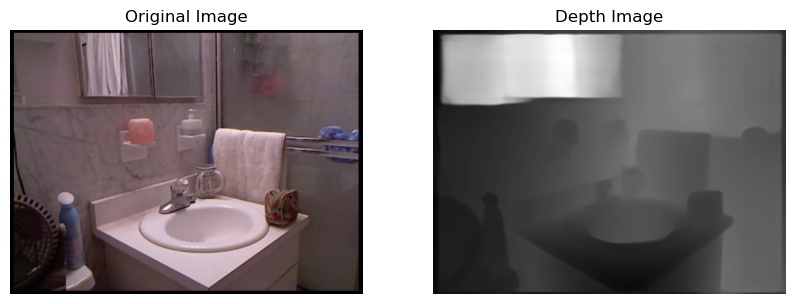

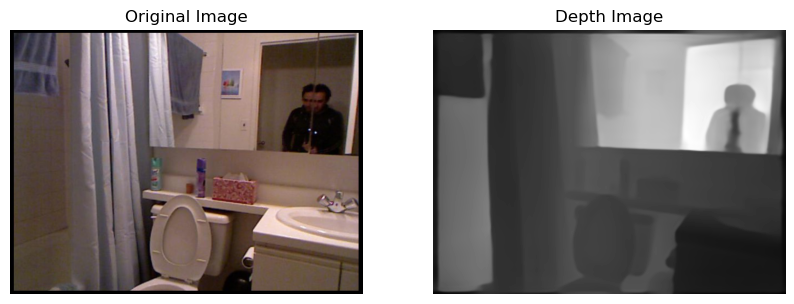

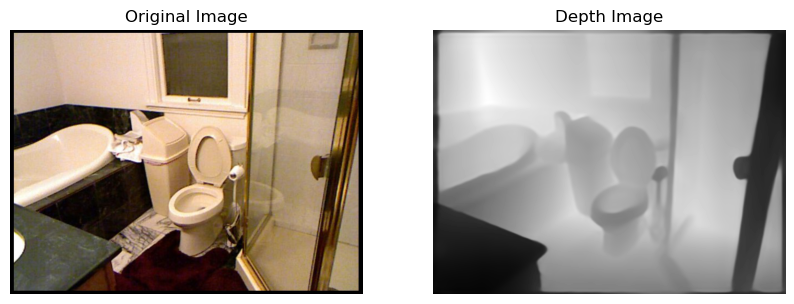

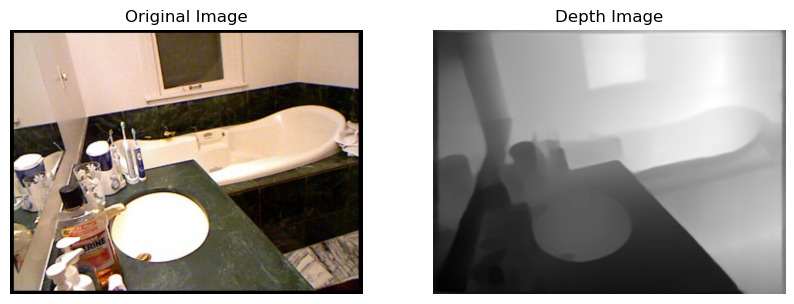

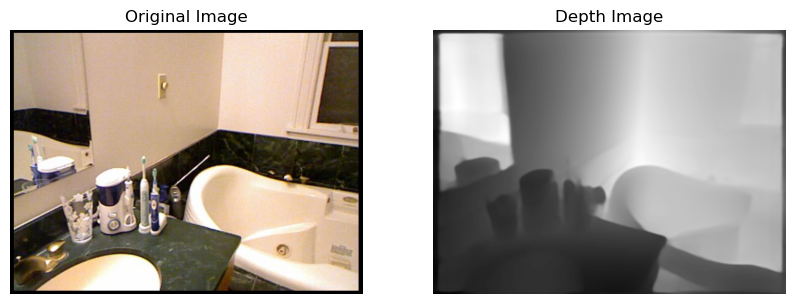

In [32]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
zoe_k_trained = model_zoe_trained.to(DEVICE)
image_dir = 'Datasets/nyu_depth_v2/test/bathroom/'  # Path where the input images are stored

# Call the function with the required arguments
process_and_plot_images(zoe_k_trained, image_dir)

Zoe NYU and Kitti

In [33]:
!python evaluate.py -m zoedepth --pretrained_resource="local::/home/irfan/shortcuts/monodepth3_checkpoints/ZoeDepthv1_14-Nov_11-06-a9ae7dc67fc1_best.pt" -d nyu

{'attractor_alpha': 1000,
 'attractor_gamma': 2,
 'attractor_kind': 'mean',
 'attractor_type': 'inv',
 'aug': True,
 'avoid_boundary': False,
 'bin_centers_type': 'softplus',
 'bin_embedding_dim': 128,
 'clip_grad': 0.1,
 'data_path': './Datasets/nyu_depth_v2/sync/',
 'data_path_eval': './Datasets/nyu_depth_v2/test/',
 'dataset': 'nyu',
 'degree': 1.0,
 'distributed': True,
 'do_kb_crop': False,
 'do_random_rotate': True,
 'eigen_crop': True,
 'filenames_file': './train_test_inputs/nyudepthv2_train_files_with_gt.txt',
 'filenames_file_eval': './train_test_inputs/nyudepthv2_test_files_with_gt.txt',
 'garg_crop': False,
 'gpu': None,
 'gt_path': './Datasets/nyu_depth_v2/sync/',
 'gt_path_eval': './Datasets/nyu_depth_v2/test/',
 'img_size': [384, 512],
 'input_height': 480,
 'input_width': 640,
 'inverse_midas': False,
 'log_images_every': 0.1,
 'max_depth': 10,
 'max_depth_diff': 10,
 'max_depth_eval': 10,
 'max_temp': 50.0,
 'max_translation': 100,
 'memory_efficient': True,
 'midas_mod

In [34]:
torch.save(model_zoe_trained.state_dict(), 'model_zoe_trained.pth')